# Initialisation

In [1]:
import datetime
from pandas.errors import EmptyDataError
import pandas as pd
import glob 


def logtofile(log_text, verbose=True):
    if verbose:
        print(log_text)
    with open(save_log_as, "a") as f:    
        print(log_text, file=f)


def csv_to_df(path):
    csv_files = glob.glob(path) 
      
    dfs = []
    for f in csv_files:       
        try:
            df = pd.read_csv(f)
            logtofile(f, False)
            if len(df) > 0:
                df['layer'] = df['name'].index + 1 
                dfs.append(df)
        except EmptyDataError:
            continue
            
    return pd.concat(dfs, ignore_index=True)
'''
style_order = [#'bw', 
               'bias', 
               'unbias',  
               'bg', 
              # 'bgonly',  
               'mix', 
               'unbias_ref',  
               #'synth'
              ]
'''
style_order = ['Correlated', 
               'Digit',  
               'Colour', 
               #'Colour-Only',  
               #'Mix', 
               'Baseline',  
               #'Noise'
              ]

# Rank plotting for Exp 1f (cut to stitch and receiver only) with 4-epoch training

Logging to ./results/2024-10-21_22-52-07_ranks_exp1f_log.txt


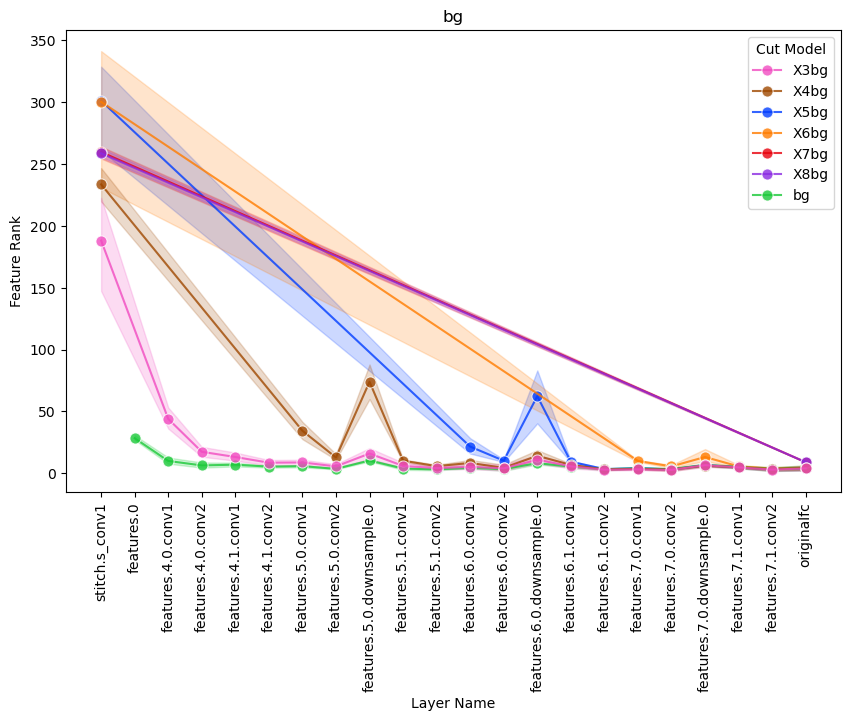

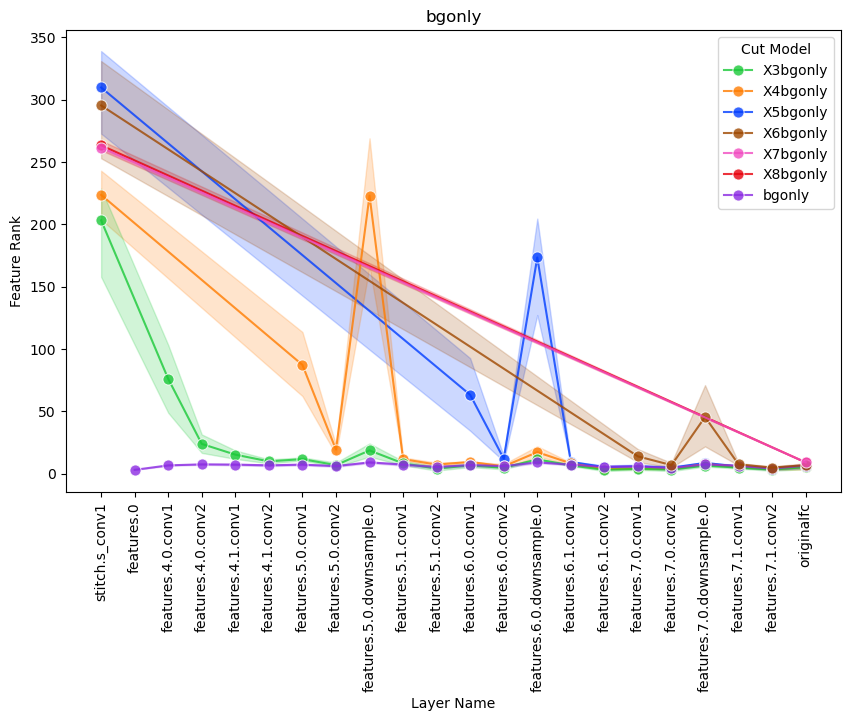

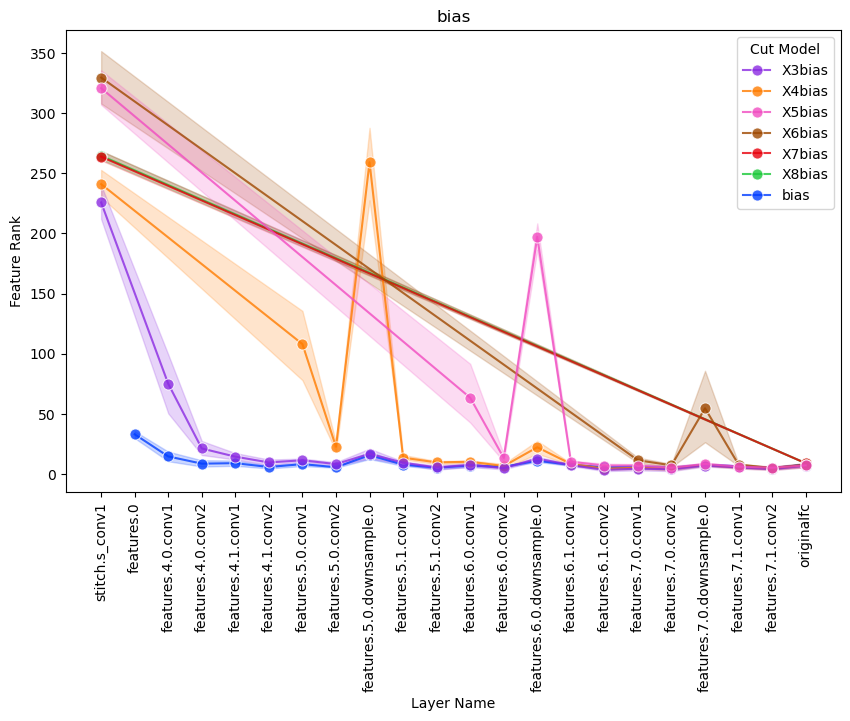

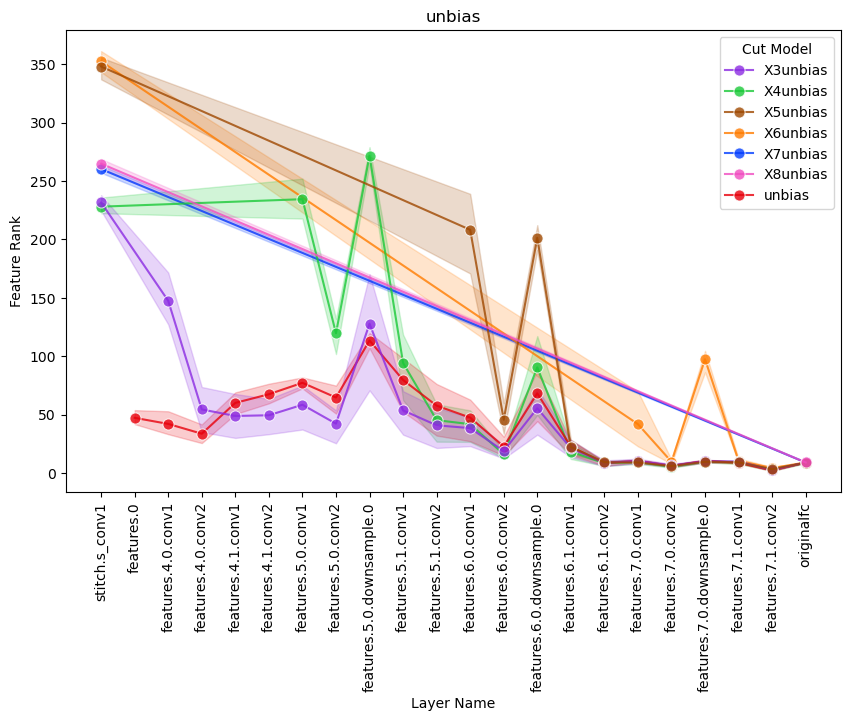

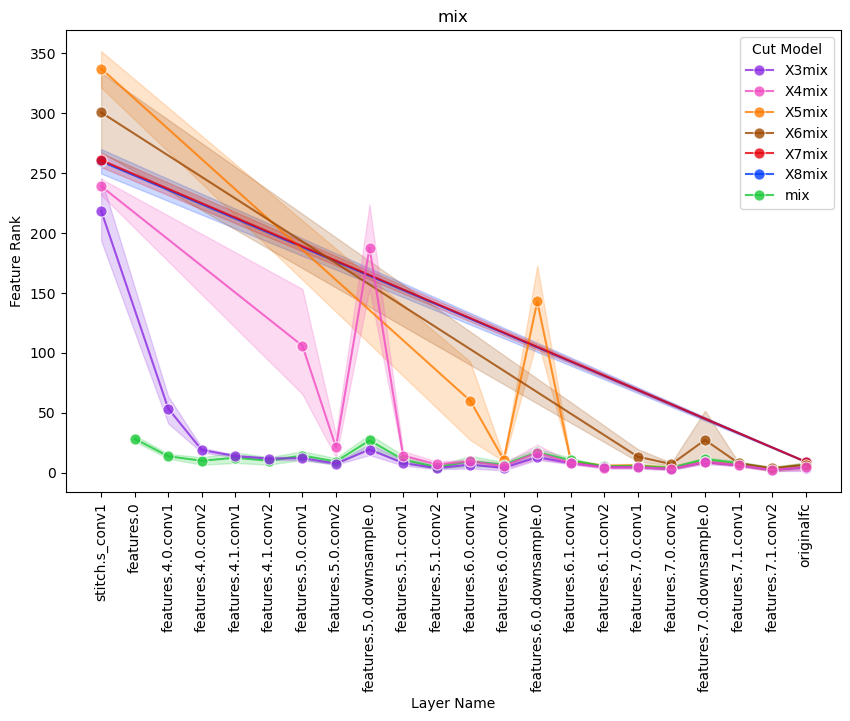

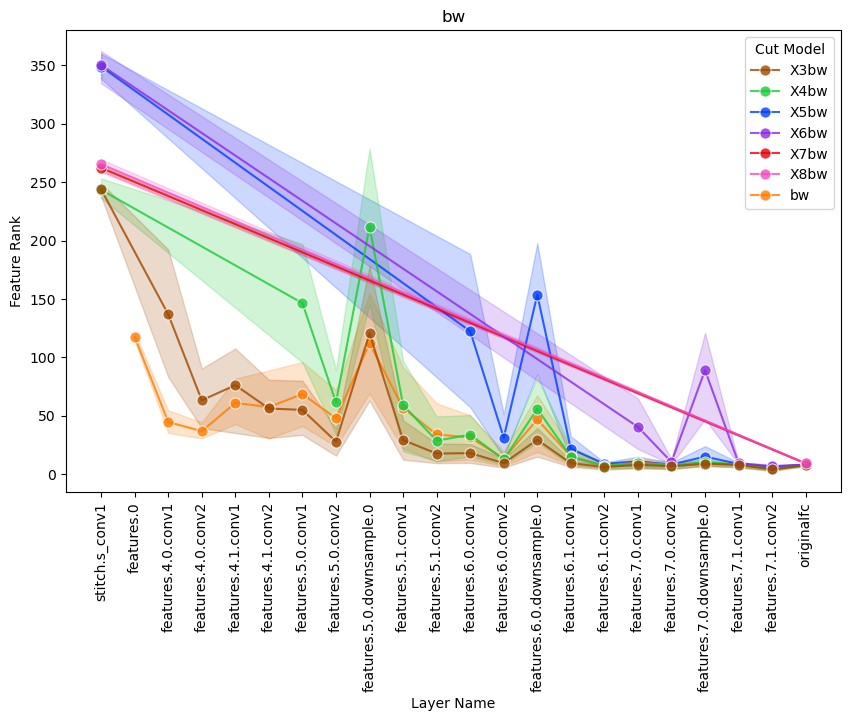

sizes={'bg': 410, 'bgonly': 410, 'bias': 410, 'unbias': 410, 'mix': 410, 'bw': 410}


In [2]:
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
logfile_name = formatted_time + "_ranks_exp1f_log.txt"
save_log_as = f"./results/{logfile_name}"
logtofile(f"Logging to {save_log_as}")
import os 
csvs_from = os.path.join("../msc_similarity/exp1_ms_with_random_dataset/results_4_epochs_rank/", "*.csv")
df = csv_to_df(csvs_from)

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# cheatingly noted the text names of the layers in order.
# Note that the stitch.s_conv1 layer appears first in the list, even though conceptually it 
# could be considered to be in the middle of the full network at the point of the cut
cat_order = ['stitch.s_conv1', 'features.0', 'features.4.0.conv1', 'features.4.0.conv2', 'features.4.1.conv1', 'features.4.1.conv2', 'features.5.0.conv1', 'features.5.0.conv2', 'features.5.0.downsample.0', 'features.5.1.conv1', 'features.5.1.conv2', 'features.6.0.conv1', 'features.6.0.conv2', 'features.6.0.downsample.0', 'features.6.1.conv1', 'features.6.1.conv2', 'features.7.0.conv1', 'features.7.0.conv2', 'features.7.0.downsample.0', 'features.7.1.conv1', 'features.7.1.conv2', 'originalfc']

graphs = {'bg': 'bg$', 'bgonly': 'bgonly', 'bias': '(?<!un)bias',  # these three may learn colours as a shortcut
          'unbias': 'unbias', 'mix': 'mix', 'bw': 'bw'}            # these three have to learn to read digits
sizes = {}
for k, v in graphs.items(): 
    matchpattern = v
    # unsorted dataframe, but filtered to include only the data for one base model type
    df2 = df[(df['model'].str.contains(matchpattern)) ].copy()
    sizes[k] = len(df2)
    # Sort the model column and create a categorical type with sorted categories 
    # e.g models are X6bgonly or bgonly
    df2['name'] = pd.Categorical(df2['name'], categories=cat_order, ordered=True)

    # Create line plot
    plt.figure(figsize=(10, 6))
    line_plot = sns.lineplot(data=df2, x='name', y='features_rank', hue='model', marker='o', markersize=8, alpha=0.8, palette='bright')
    
    plt.title(k)
    plt.xlabel('Layer Name')
    plt.ylabel('Feature Rank')
    plt.xticks(rotation=90)
    
    handles, labels = line_plot.get_legend_handles_labels()
    sorted_labels_handles = sorted(zip(labels, handles))
    labels, handles = zip(*sorted_labels_handles)
    plt.legend(handles, labels, title='Cut Model', loc='upper right')
    plt.savefig(f"./results/{k}_rank.png", bbox_inches='tight')
    plt.show()
print(f"{sizes=}")

# 1f: Combine synthetic stitch data into one graph
each series represents one type of receiver network
the horizontal axis represents first layer of the receiver network

Logging to ./results/2024-10-21_22-52-22_ranks_exp1f_log.txt
Check number of samples per model:
{'unbias_ref': 2460, 'bg': 2460, 'bgonly': 2460, 'bias': 2460, 'unbias': 2460, 'mix': 2460, 'bw': 2460}
Check number of samples per model:
{'unbias_ref': 175, 'bg': 175, 'bgonly': 175, 'bias': 175, 'unbias': 175, 'mix': 175, 'bw': 175}


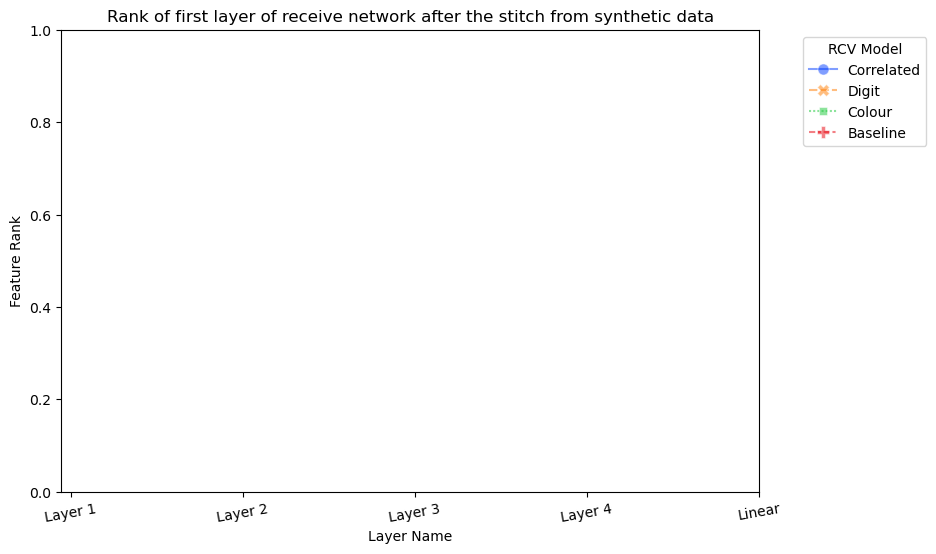

In [3]:
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
logfile_name = formatted_time + "_ranks_exp1f_log.txt"
save_log_as = f"./results/{logfile_name}"
logtofile(f"Logging to {save_log_as}")
import os 

# exp1 Synthetic stitch
csvs_from = os.path.join("../msc_similarity/exp1_ms_with_random_dataset/results_4_epochs_rank/", "*.csv")
df = csv_to_df(csvs_from)

rcv_models  = {'unbias_ref': '^unbias$',
               'bg':         'bg$', # these three may learn colours as a shortcut
               'bgonly':     'bgonly', 
               'bias':       '\dbias',  
               'unbias':     '\dunbias', # these three have to learn to read digits
               'mix':        'mix', 
               'bw':         'bw'}

df['receiver'] = 'unknown'
sizes = {}
for k, v in rcv_models.items(): 
        
    # unsorted dataframe, but filtered to include only the data for one send model type
    selected_set = (df['model'].str.contains(v))
    df.loc[selected_set, 'receiver'] = k
    sizes[k] = len((df['model'].str.contains(v)))

# Check numbers of samples per model
print(f"Check number of samples per model:\n{sizes}")

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# cheatingly noted the text names of the layers in order.
# Note that the stitch.s_conv1 layer appears first in the list, even though conceptually it 
# could be considered to be in the middle of the full network at the point of the cut
# This made sense for the truncated networks in part 1 but not 
layer_after_stitch = {3: 'features.4.0.conv1',
                      4: 'features.5.0.conv1',
                      5: 'features.6.0.conv1',
                      6: 'features.7.0.conv1',
                      7: 'originalfc'}

category_order = ['features.4.0.conv1',  
                  'features.5.0.conv1',  
                  'features.6.0.conv1', 
                  'features.7.0.conv1',  
                  'originalfc']

custom_labels = ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Linear']


combined_condition = pd.Series([False] * len(df))

sizes = {}
for k, v in layer_after_stitch.items(): 

    model_match = (df['model'].str.contains(f"{k}"))
    layer_match = (df['name'].str.contains(v))
    combined_condition |= (model_match & layer_match)
    
    # Add in the reference model that has no stitch, was trained on unbias dataset 
    model_match = (df['model'].str.contains(rcv_models['unbias_ref']))
    layer_match = (df['name'].str.contains(v))
    combined_condition |= (model_match & layer_match)

df2 = df[combined_condition ].copy() 
df3 = df2[df2['receiver'] != 'unknown'].copy()

#########################
sizes = {}
for k, v in rcv_models.items():         
    # Now that d3 has been filtered down, check again how many samples per model
    sizes[k] = len((df3['model'].str.contains(v)))

# Check numbers of samples per model
print(f"Check number of samples per model:\n{sizes}")
#######################

# Sort the model column and create a categorical type with sorted categories 
# e.g models are X6bgonly or bgonly
df3['name'] = pd.Categorical(df3['name'], categories=category_order, ordered=True)
# Create line plot
plt.figure(figsize=(9,6))

line_plot = sns.lineplot(data=df3, x='name', y='features_rank', hue='receiver', style='receiver', 
                         hue_order=style_order, style_order=style_order,
                         markers=True, dashes=True, markersize=8, alpha=0.5, palette='bright',
                        errorbar=("sd",1))  # One Standard Deviation

plt.title("Rank of first layer of receive network after the stitch from synthetic data")
plt.xlabel('Layer Name')
plt.ylabel('Feature Rank')
#plt.yscale('log')
plt.xticks(rotation=10)

handles, labels = line_plot.get_legend_handles_labels()
#sorted_labels_handles = sorted(zip(labels, handles))
unsorted_labels_handles = zip(labels[:len(rcv_models)], handles[:len(rcv_models)])
labels, handles = zip(*unsorted_labels_handles)
plt.legend(handles, labels, title='RCV Model', loc='upper right', bbox_to_anchor=(1.25, 1))
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)
plt.savefig(f"./results/1f_lin_post_stitch_ranks.png", bbox_inches='tight')
plt.show()



## And plot val accuracies

Logging to ./results/2024-10-21_22-52-24_ranks_exp1f_log.txt
Check number of samples per model:
{'bg': 4920, 'bgonly': 4920, 'bias': 4920, 'unbias': 4920, 'mix': 4920, 'bw': 4920}
Check number of samples per model:
{'bg': 180, 'bgonly': 180, 'bias': 180, 'unbias': 180, 'mix': 180, 'bw': 180}


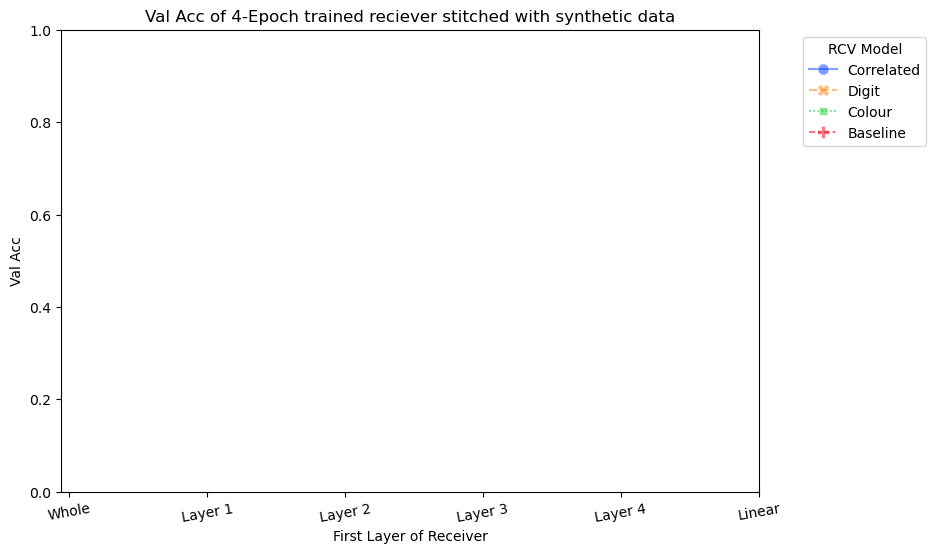

In [4]:
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
logfile_name = formatted_time + "_ranks_exp1f_log.txt"
save_log_as = f"./results/{logfile_name}"
logtofile(f"Logging to {save_log_as}")
import os 

# exp1 Synthetic stitch
csvs_from = os.path.join("../msc_similarity/exp1_ms_with_random_dataset/results_4_epochs_rank/", "*.csv")
df = csv_to_df(csvs_from)

rcv_models  = {
               'bg':         'bg$', # these three may learn colours as a shortcut
               'bgonly':     'bgonly', 
               'bias':       '\dbias',  
               'unbias':     '\dunbias', # these three have to learn to read digits
               'mix':        'mix', 
               'bw':         'bw'}

# The models which have no stitch - use to get a first point on the graph for training against real data
ref_models  = {
               'bg':         '^bg$', # these three may learn colours as a shortcut
               'bgonly':     '^bgonly$', 
               'bias':       '^bias$',  
               'unbias':     '^unbias$', # these three have to learn to read digits
               'mix':        '^mix$', 
               'bw':         '^bw$'}

df['receiver'] = 'unknown'
sizes = {}
for k, v in rcv_models.items(): 
        
    # unsorted dataframe, but filtered to include only the data for one send model type
    selected_set = (df['model'].str.contains(v))
    df.loc[selected_set, 'receiver'] = k
    sizes[k] = len((df['model'].str.contains(v)))
    
for k, v in ref_models.items(): 
        
    # unsorted dataframe, but filtered to include only the data for one send model type
    selected_set = (df['model'].str.contains(v))
    df.loc[selected_set, 'receiver'] = k
    sizes[k] += len((df['model'].str.contains(v)))

# Check numbers of samples per model
print(f"Check number of samples per model:\n{sizes}")

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

layer_after_stitch = {3: 'features.4.0.conv1',
                      4: 'features.5.0.conv1',
                      5: 'features.6.0.conv1',
                      6: 'features.7.0.conv1',
                      7: 'originalfc'}

category_order = ['ref',
                  'features.4.0.conv1',  
                  'features.5.0.conv1',  
                  'features.6.0.conv1', 
                  'features.7.0.conv1',  
                  'originalfc']

custom_labels = ['Whole', 'Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Linear']

combined_condition = pd.Series([False] * len(df))

sizes = {}
for k, v in layer_after_stitch.items(): 

    model_match = (df['model'].str.contains(f"{k}"))
    layer_match = (df['name'].str.contains(v)) # layer name
    combined_condition |= (model_match & layer_match)

for k, v in ref_models.items():
    # Add in the reference model that has no stitch, was trained on unbias dataset 
    model_match = (df['model'].str.contains(v))
    layer_match = (df['name'].str.contains('features.0')) # layer name simply choose first one
    combined_condition |= (model_match & layer_match)

df2 = df[combined_condition ].copy() 
df3 = df2[df2['receiver'] != 'unknown'].copy()
selected_set = (df3['name'].str.contains('features.0'))
df3.loc[selected_set, 'name'] = 'ref'

#########################
sizes = {}
for k, v in rcv_models.items():         
    # Now that d3 has been filtered down, check again how many samples per model
    sizes[k] = len((df3['model'].str.contains(v)))

# Check numbers of samples per model
print(f"Check number of samples per model:\n{sizes}")
#######################

# Sort the model column and create a categorical type with sorted categories 
# e.g models are X6bgonly or bgonly
df3['name'] = pd.Categorical(df3['name'], categories=category_order, ordered=True)

# Create line plot
plt.figure(figsize=(9,6))

line_plot = sns.lineplot(data=df3, x='name', y='val_acc', hue='receiver', style='receiver', 
                         hue_order=style_order, style_order=style_order,
                         markers=True, dashes=True, markersize=8, alpha=0.5, palette='bright',
                        errorbar=("sd",1))
# errorbar=("pi",100)) for full range of all results

plt.title("Val Acc of 4-Epoch trained reciever stitched with synthetic data")
plt.xlabel('First Layer of Receiver')
plt.ylabel('Val Acc')
#plt.yscale('log')
plt.xticks(rotation=10)

handles, labels = line_plot.get_legend_handles_labels()
#sorted_labels_handles = sorted(zip(labels, handles))
unsorted_labels_handles = zip(labels[:len(ref_models)], handles[:len(ref_models)])
labels, handles = zip(*unsorted_labels_handles)
plt.legend(handles, labels, title='RCV Model', loc='upper right', bbox_to_anchor=(1.25, 1))
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels) # rename ticks
plt.savefig(f"./results/1f_lin_post_stitch_acc.png", bbox_inches='tight')
plt.show()

# 1g: Combine synthetic stitch data into one graph for VGG19 networks
each series represents one type of receiver network
the horizontal axis represents first layer of the receiver network

In [5]:
#import torchvision
#mdl = torchvision.models.vgg19(weights=None, num_classes=10)
#print(mdl)

Logging to ./results_1g/2024-10-21_22-52-25_ranks_exp1g_log.txt
Check number of samples per model:
{'Baseline': 1350, 'Colour': 1350, 'Colour-Only': 1350, 'Correlated': 1350, 'Digit': 1350}
Check number of samples per model:
{'Baseline': 132, 'Colour': 132, 'Colour-Only': 132, 'Correlated': 132, 'Digit': 132}


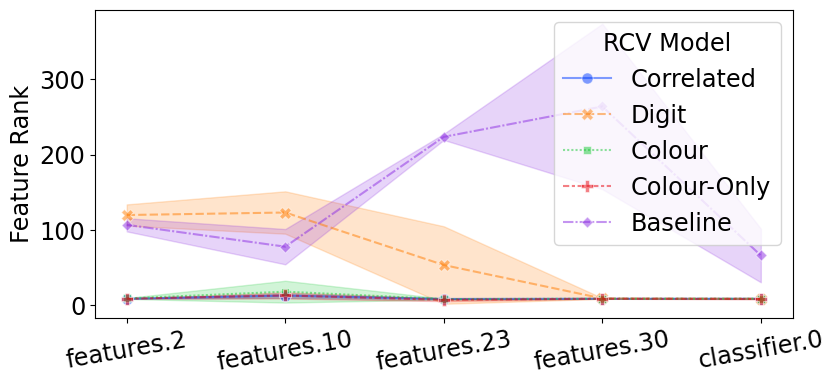

In [6]:
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
logfile_name = formatted_time + "_ranks_exp1g_log.txt"
save_log_as = f"./results_1g/{logfile_name}"
logtofile(f"Logging to {save_log_as}")
import os 

# exp1 Synthetic stitch
csvs_from = os.path.join("../msc_similarity/exp1_ms_with_random_dataset/results_1g_rank/", "*.csv")
df = csv_to_df(csvs_from)

style_order = ['Correlated', 
               'Digit',  
               'Colour', 
               'Colour-Only',  
               #'Mix', 
               'Baseline',  
               #'Noise'
              ]

rcv_models  = {'Baseline': '^unbias$',
               'Colour':         'bg$', # these three may learn colours as a shortcut
               'Colour-Only':     'bgonly', 
               'Correlated':       '\dbias',  
               'Digit':     '\dunbias', # these three have to learn to read digits
               #'mix':        'mix', 
               #'bw':         'bw'
              }

df['receiver'] = 'unknown'
sizes = {}
for k, v in rcv_models.items(): 
        
    # unsorted dataframe, but filtered to include only the data for one send model type
    selected_set = (df['model'].str.contains(v))
    df.loc[selected_set, 'receiver'] = k
    sizes[k] = len((df['model'].str.contains(v)))

# Check numbers of samples per model
print(f"Check number of samples per model:\n{sizes}")

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

layer_after_stitch = {1: 'features.2'  ,
                      8: 'features.10'  ,
                     22: 'features.23' ,
                     29: 'features.30' ,
                     35: 'classifier.0'
                     }

category_order = ['features.2'  ,
                  'features.10'  ,
                  'features.23' ,
                  'features.30' ,
                  'classifier.0']

custom_labels = category_order


combined_condition = pd.Series([False] * len(df))

sizes = {}
for k, v in layer_after_stitch.items(): 

    model_match = (df['model'].str.contains(f"{k}"))
    layer_match = (df['name'].str.contains(v))
    combined_condition |= (model_match & layer_match)
    
    # Add in the reference model that has no stitch, was trained on unbias dataset 
    model_match = (df['model'].str.contains(rcv_models['Baseline']))
    layer_match = (df['name'].str.contains(v))
    combined_condition |= (model_match & layer_match)

df2 = df[combined_condition ].copy() 
df3 = df2[df2['receiver'] != 'unknown'].copy()

#########################
sizes = {}
for k, v in rcv_models.items():         
    # Now that d3 has been filtered down, check again how many samples per model
    sizes[k] = len((df3['model'].str.contains(v)))

# Check numbers of samples per model
print(f"Check number of samples per model:\n{sizes}")
#######################

# Sort the model column and create a categorical type with sorted categories 
# e.g models are X6bgonly or bgonly
df3['name'] = pd.Categorical(df3['name'], categories=category_order, ordered=True)
# Create line plot
plt.figure(figsize=(9,4))

line_plot = sns.lineplot(data=df3, x='name', y='features_rank', hue='receiver', style='receiver', 
                         hue_order=style_order, style_order=style_order,
                         markers=True, dashes=True, markersize=8, alpha=0.5, palette='bright',
                        errorbar=("sd",1))

#plt.title("Rank of first layer of VGG19 receivers after the stitch from synthetic data")
#plt.xlabel('Layer Name')
plt.xlabel('')
plt.ylabel('Feature Rank', fontsize='xx-large')
#plt.yscale('log')
plt.xticks(rotation=10)
plt.tick_params(axis='both', labelsize='xx-large')

handles, labels = line_plot.get_legend_handles_labels()
#sorted_labels_handles = sorted(zip(labels, handles))
unsorted_labels_handles = zip(labels[:len(rcv_models)], handles[:len(rcv_models)])
labels, handles = zip(*unsorted_labels_handles)
plt.legend(handles, labels, title='RCV Model', loc='upper right', bbox_to_anchor=(1, 1), fontsize='xx-large', title_fontsize='xx-large')
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)
#plt.savefig(f"./results_1g/1g_lin_post_stitch_ranks.png", bbox_inches='tight')
plt.savefig(f"./results_1g/1g_lin_post_stitch_ranks.pdf", bbox_inches='tight')
plt.show()



## And plot val accuracies

Logging to ./results_1g/2024-10-21_22-52-26_ranks_exp1g_log.txt
Check number of samples per model:
{'Colour': 2700, 'Colour-Only': 2700, 'Correlated': 2700, 'Digit': 2700}
Check number of samples per model:
{'Colour': 120, 'Colour-Only': 120, 'Correlated': 120, 'Digit': 120}


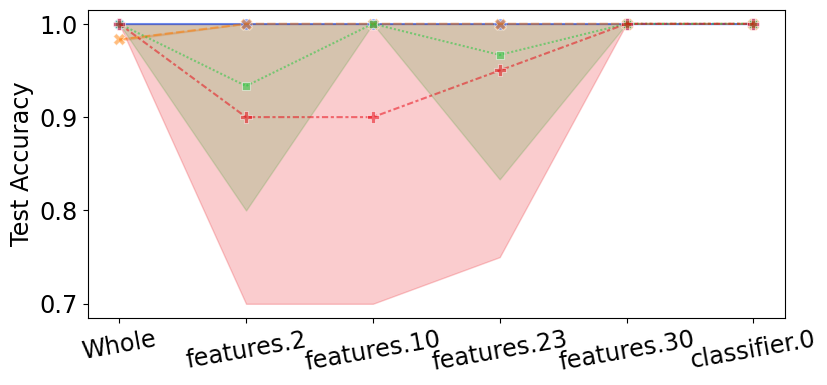

In [7]:
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
logfile_name = formatted_time + "_ranks_exp1g_log.txt"
save_log_as = f"./results_1g/{logfile_name}"
logtofile(f"Logging to {save_log_as}")
import os 

# exp1 Synthetic stitch
csvs_from = os.path.join("../msc_similarity/exp1_ms_with_random_dataset/results_1g_rank/", "*.csv")
df = csv_to_df(csvs_from)
style_order = ['Correlated', 
               'Digit',  
               'Colour', 
               'Colour-Only',  
               #'Mix', 
               #'Baseline',  
               #'Noise'
              ]
rcv_models  = {
               'Colour':         'bg$', # these three may learn colours as a shortcut
               'Colour-Only':     'bgonly', 
               'Correlated':       '\dbias',  
               'Digit':       '\dunbias', # these three have to learn to read digits
               #'mix':        'mix', 
               #'bw':         'bw'
               }

# The models which have no stitch - use to get a first point on the graph for training against real data
ref_models  = {
               'Colour':          '^bg$', # these three may learn colours as a shortcut
               'Colour-Only':     '^bgonly$', 
               'Correlated':      '^bias$',  
               'Digit':           '^unbias$', # these three have to learn to read digits
               #'mix':        '^mix$', 
               #'bw':         '^bw$'
                }

df['receiver'] = 'unknown'
sizes = {}
for k, v in rcv_models.items(): 
        
    # unsorted dataframe, but filtered to include only the data for one send model type
    selected_set = (df['model'].str.contains(v))
    df.loc[selected_set, 'receiver'] = k
    sizes[k] = len((df['model'].str.contains(v)))
    
for k, v in ref_models.items(): 
        
    # unsorted dataframe, but filtered to include only the data for one send model type
    selected_set = (df['model'].str.contains(v))
    df.loc[selected_set, 'receiver'] = k
    sizes[k] += len((df['model'].str.contains(v)))

# Check numbers of samples per model
print(f"Check number of samples per model:\n{sizes}")

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch


category_order = ['ref', 
                  'features.2'  ,
                  'features.10'  ,
                  'features.23' ,
                  'features.30' ,
                  'classifier.0']

custom_labels =  ['Whole', 
                  'features.2'  ,
                  'features.10'  ,
                  'features.23' ,
                  'features.30' ,
                  'classifier.0']

combined_condition = pd.Series([False] * len(df))

sizes = {}
for k, v in layer_after_stitch.items(): 

    model_match = (df['model'].str.contains(f"{k}"))
    layer_match = (df['name'].str.contains(v)) # layer name
    combined_condition |= (model_match & layer_match)

for k, v in ref_models.items():
    # Add in the reference model that has no stitch, was trained on unbias dataset 
    model_match = (df['model'].str.contains(v))
    layer_match = (df['name'].str.contains('features.0')) # layer name simply choose first one
    combined_condition |= (model_match & layer_match)

df2 = df[combined_condition ].copy() 
df3 = df2[df2['receiver'] != 'unknown'].copy()
selected_set = (df3['name'].str.contains('features.0'))
df3.loc[selected_set, 'name'] = 'ref'

#########################
sizes = {}
for k, v in rcv_models.items():         
    # Now that d3 has been filtered down, check again how many samples per model
    sizes[k] = len((df3['model'].str.contains(v)))

# Check numbers of samples per model
print(f"Check number of samples per model:\n{sizes}")
#######################

# Sort the model column and create a categorical type with sorted categories 
# e.g models are X6bgonly or bgonly
df3['name'] = pd.Categorical(df3['name'], categories=category_order, ordered=True)

# Create line plot
plt.figure(figsize=(9,4))

line_plot = sns.lineplot(data=df3, x='name', y='val_acc', hue='receiver', style='receiver', 
                         hue_order=style_order, style_order=style_order,
                         markers=True, dashes=True, markersize=8, alpha=0.5, palette='bright',
                        errorbar=("ci",100))
# errorbar=("sd",1)) for standard dev
# errorbar=("ci",100) would give 100% confidence interval "pi" is percentile interval

#plt.title("Val Acc of VGG19 recievers stitched with synthetic data")
#plt.xlabel('First Layer of Receiver')
plt.xlabel('')
plt.ylabel('Test Accuracy', fontsize='xx-large')
#plt.yscale('log')
plt.xticks(rotation=10)
plt.tick_params(axis='both', labelsize='xx-large')

handles, labels = line_plot.get_legend_handles_labels()
#sorted_labels_handles = sorted(zip(labels, handles))
unsorted_labels_handles = zip(labels[:len(ref_models)], handles[:len(ref_models)])
labels, handles = zip(*unsorted_labels_handles)
plt.legend(handles, labels, title='RCV Model', loc='upper right', bbox_to_anchor=(1.25, 1))
plt.legend().remove()
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels) # rename ticks
#plt.savefig(f"./results_1g/1g_lin_post_stitch_acc.png", bbox_inches='tight')
plt.savefig(f"./results_1g/1g_lin_post_stitch_acc_sd.pdf", bbox_inches='tight')
plt.show()

## List validation accuracies of whole networks on original data

In [8]:
# Calculate validation accuracy of un-stitched networks on biased data

formatted_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
logfile_name = formatted_time + "_ranks_exp1g_log.txt"
save_log_as = f"./results_1g/{logfile_name}"
logtofile(f"Logging to {save_log_as}")
import os 

# exp2 colour_MNIST
csvs_from = os.path.join("../msc_similarity/exp1_ms_with_random_dataset/results_1g_rank/", "*.csv")
df1 = csv_to_df(csvs_from)

# The models which have no stitch - use to get a first point on the graph for training against real data
ref_models  = {
               'bg':         '^bg$', # these three may learn colours as a shortcut
               'bgonly':     '^bgonly$', 
               'bias':       '^bias$',  
               'unbias':     '^unbias$', # these three have to learn to read digits
               'mix':        '^mix$', 
               'bw':         '^bw$'}

combined_condition = pd.Series([False] * len(df))

accuracies = {}
for k, v in ref_models.items(): 

    model_match = (df['model'].str.contains(v))
    layer_match = (df['name'].str.contains('features.0'))
    condition = (model_match & layer_match)
    print(f"For {k} found {sum(condition)} examples")
    #combined_condition |= condition
    #print(df[condition]['val_acc'])
    #print(df[condition]['val_acc'].mean())
    accuracies[k] = df[condition]['val_acc'].mean()

print("The following networks with validation accuracies measured against their related datasets")
print(accuracies)


Logging to ./results_1g/2024-10-21_22-52-27_ranks_exp1g_log.txt
For bg found 3 examples
For bgonly found 3 examples
For bias found 3 examples
For unbias found 3 examples
For mix found 3 examples
For bw found 3 examples
The following networks with validation accuracies measured against their related datasets
{'bg': 1.0, 'bgonly': 1.0, 'bias': 1.0, 'unbias': 0.9831666549046835, 'mix': 0.9931333065032959, 'bw': 0.9889999628067017}


Logging to ./results_2/2024-10-21_22-52-27_ranks_exp2_log.txt
Check number of samples per model:
{'unbias_ref': 7710, 'bg': 7710, 'bgonly': 7710, 'bias': 7710, 'unbias': 7710, 'mix': 7710, 'bw': 7710, 'synth': 7710}
Check number of samples per model:
{'unbias_ref': 310, 'bg': 310, 'bgonly': 310, 'bias': 310, 'unbias': 310, 'mix': 310, 'bw': 310, 'synth': 310}


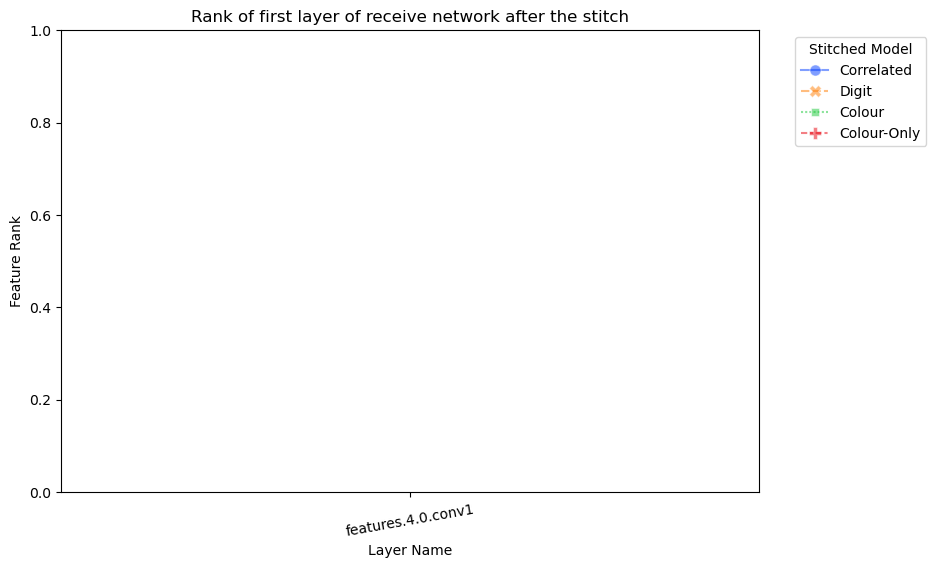

In [9]:
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
logfile_name = formatted_time + "_ranks_exp2_log.txt"
save_log_as = f"./results_2/{logfile_name}"
logtofile(f"Logging to {save_log_as}")
import os 

# exp2 colour_MNIST
csvs_from = os.path.join("../msc_similarity/exp2_ms_with_colorMNIST/results_rank/", "*.csv")
df1 = csv_to_df(csvs_from)

# exp1 Synthetic stitch
csvs_from = os.path.join("../msc_similarity/exp1_ms_with_random_dataset/results_rank/", "*.csv")
df2 = csv_to_df(csvs_from)

# select only the data for synthetic data stitched into the unbias-trained network 
df3 = df2[df2['model'].str.contains('^X\dunbias')].copy()

df = pd.concat([df1, df3], ignore_index=True)
del df1, df2, df3

# Edit names to match the whole-network naming
df['name'] = df['name'].str.replace(r'_rcv_', '', regex=True)
df['name'] = df['name'].str.replace(r'^rcv_', '', regex=True)
df['name'] = df['name'].str.replace(r'^send_', '', regex=True)

send_models = {'unbias_ref': '^unbias$',
               'bg':         '^bg\d', # these three may learn colours as a shortcut
               'bgonly':     '^bgonly\d', 
               'bias':       '^bias\d',  
               'unbias':     '^unbias\d', # these three have to learn to read digits
               'mix':        '^mix\d', 
               'bw':         '^bw\d',
               'synth':      '^X\dunbias'} # syntetic random data stitched in

df['sender'] = 'unknown'
sizes = {}
for k, v in send_models.items(): 
        
    # unsorted dataframe, but filtered to include only the data for one send model type
    selected_set = (df['model'].str.contains(v))
    df.loc[selected_set, 'sender'] = k
    sizes[k] = len((df['model'].str.contains(v)))

# Check numbers of samples per model
print(f"Check number of samples per model:\n{sizes}")

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# cheatingly noted the text names of the layers in order.
# Note that the stitch.s_conv1 layer appears first in the list, even though conceptually it 
# could be considered to be in the middle of the full network at the point of the cut
# This made sense for the truncated networks in part 1 but not 
layer_after_stitch = {3: 'features.4.0.conv1',
                      4: 'features.5.0.conv1',
                      5: 'features.6.0.conv1',
                      6: 'features.7.0.conv1',
                      7: 'originalfc'}

cat_order = ['features.4.0.conv1',  
             'features.5.0.conv1',  
             'features.6.0.conv1', 
             'features.7.0.conv1',  
             'originalfc']

combined_condition = pd.Series([False] * len(df))

sizes = {}
for k, v in layer_after_stitch.items(): 

    model_match = (df['model'].str.contains(f"{k}"))
    layer_match = (df['name'].str.contains(v))
    combined_condition |= (model_match & layer_match)

    # Add in the reference model that has no stitch, was trained on unbias dataset but has bias data input to it
    model_match = (df['model'].str.contains(send_models['unbias_ref']))
    layer_match = (df['name'].str.contains(v))
    combined_condition |= (model_match & layer_match)

df2 = df[combined_condition ].copy() 
df3 = df2[df2['sender'] != 'unknown'].copy()

#########################
sizes = {}
for k, v in send_models.items():         
    # Now that d3 has been filtered down, check again how many samples per model
    sizes[k] = len((df3['model'].str.contains(v)))

# Check numbers of samples per model
print(f"Check number of samples per model:\n{sizes}")
#######################

# Sort the model column and create a categorical type with sorted categories 
# e.g models are X6bgonly or bgonly
df3['name'] = pd.Categorical(df3['name'], categories=cat_order, ordered=True)
# Create line plot
plt.figure(figsize=(9,6))

line_plot = sns.lineplot(data=df3, x='name', y='features_rank', hue='sender', style='sender',
                         hue_order=style_order, style_order=style_order,
                         markers=True, dashes=True, markersize=8, alpha=0.5, palette='bright')

plt.title("Rank of first layer of receive network after the stitch")
plt.xlabel('Layer Name')
plt.ylabel('Feature Rank')
#plt.yscale('log')
plt.xticks(rotation=10)

handles, labels = line_plot.get_legend_handles_labels()
#sorted_labels_handles = sorted(zip(labels, handles))
unsorted_labels_handles = zip(labels, handles)
labels, handles = zip(*unsorted_labels_handles)
plt.legend(handles, labels, title='Stitched Model', loc='upper right', bbox_to_anchor=(1.25, 1))
plt.savefig(f"./results_2d/lin_post_stitch_ranks.png", bbox_inches='tight')
plt.show()




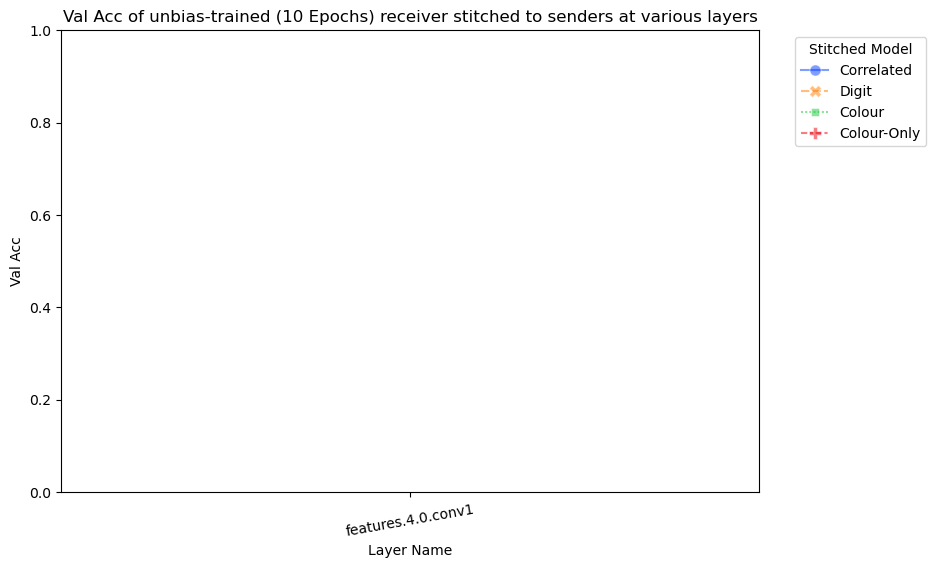

In [10]:
# Create line plot
plt.figure(figsize=(9,6))
#line_plot = sns.lineplot(data=df3, x='name', y='features_rank', hue='sender', marker='o', markersize=8, alpha=0.5, palette='bright')
line_plot = sns.lineplot(data=df3, x='name', y='val_acc', hue='sender', style='sender', 
                         hue_order=style_order, style_order=style_order,
                         markers=True, dashes=True, markersize=8, alpha=0.5, palette='bright',
                        errorbar=("pi",100))

plt.title("Val Acc of unbias-trained (10 Epochs) receiver stitched to senders at various layers")
plt.xlabel('Layer Name')
plt.ylabel('Val Acc')
#plt.yscale('log')
plt.xticks(rotation=10)

handles, labels = line_plot.get_legend_handles_labels()
#sorted_labels_handles = sorted(zip(labels, handles))
unsorted_labels_handles = zip(labels, handles)
labels, handles = zip(*unsorted_labels_handles)
plt.legend(handles, labels, title='Stitched Model', loc='upper right', bbox_to_anchor=(1.25, 1))
plt.savefig(f"./results_2d/2d_lin_post_stitch_acc.png", bbox_inches='tight')
plt.show()


# Experiment 2e - Plot Rank After Stitch - 4 Epoch Trained
Networks trained for 4 epochs. Stitch trained for 10 epochs.
Measure the Rank of the activations in the first layer of the receiver network after the stitch. If the Sender + Stitch were equivalent to the early layers of the receiver network then the rank (after processing by the Receiver) should be unchanged. 

Logging to ./results_2e/2024-10-21_22-52-29_ranks_exp2_log.txt
Check number of samples per model:
{'Baseline': 4933, 'Colour': 4933, 'Colour-Only': 4933, 'Correlated': 4933, 'Digit': 4933, 'Noise': 4933}
Check number of samples per model:
{'Baseline': 152, 'Colour': 152, 'Colour-Only': 152, 'Correlated': 152, 'Digit': 152, 'Noise': 152}


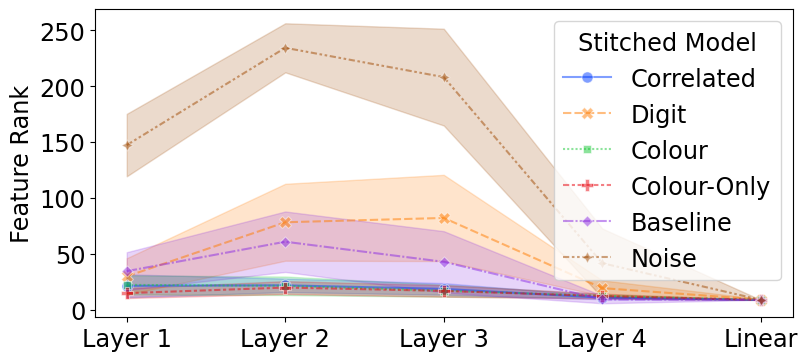

In [11]:
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
logfile_name = formatted_time + "_ranks_exp2_log.txt"
save_log_as = f"./results_2e/{logfile_name}"
logtofile(f"Logging to {save_log_as}")
import os 

# styles to reproduce graph A5 of the NeurIPS paper "AllAcc/RankToDigit"
makeAllRanks = True
if makeAllRanks:
    style_order = ['Correlated', 
                   'Digit',  
                   'Colour', 
                   'Colour-Only',  
                   #'Mix', 
                   'Baseline',  
                   'Noise'
                  ]
    send_models = {'Baseline': '^unbias$',
                   'Colour':         '^bg\d', # these three may learn colours as a shortcut
                   'Colour-Only':     '^bgonly\d', 
                   'Correlated':       '^bias\d',  
                   'Digit':     '^unbias\d', # these three have to learn to read digits
                   #'Mix':        '^mix\d', 
                   #'bw':         '^bw\d',
                   'Noise':      '^X\dunbias' # syntetic random data stitched in
                  }


# exp2 colour_MNIST
csvs_from = os.path.join("../msc_similarity/exp2_ms_with_colorMNIST/results_4_epochs_rank/", "*.csv")
df1 = csv_to_df(csvs_from)

# exp1 Synthetic stitch
csvs_from = os.path.join("../msc_similarity/exp1_ms_with_random_dataset/results_4_epochs_rank/", "*.csv")
df2 = csv_to_df(csvs_from)

# select only the data for synthetic data stitched into the unbias-trained network 
df3 = df2[df2['model'].str.contains('^X\dunbias')].copy()

df = pd.concat([df1, df3], ignore_index=True)
del df1, df2, df3

# Edit names to match the whole-network naming
df['name'] = df['name'].str.replace(r'_rcv_', '', regex=True)
df['name'] = df['name'].str.replace(r'^rcv_', '', regex=True)
df['name'] = df['name'].str.replace(r'^send_', '', regex=True)

df['sender'] = 'unknown'
sizes = {}
for k, v in send_models.items(): 
        
    # unsorted dataframe, but filtered to include only the data for one send model type
    selected_set = (df['model'].str.contains(v))
    df.loc[selected_set, 'sender'] = k
    sizes[k] = len((df['model'].str.contains(v)))

# Check numbers of samples per model
print(f"Check number of samples per model:\n{sizes}")

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# cheatingly noted the text names of the layers in order.
# Note that the stitch.s_conv1 layer appears first in the list, even though conceptually it 
# could be considered to be in the middle of the full network at the point of the cut
# This made sense for the truncated networks in part 1 but not 
layer_after_stitch = {3: 'features.4.0.conv1',
                      4: 'features.5.0.conv1',
                      5: 'features.6.0.conv1',
                      6: 'features.7.0.conv1',
                      7: 'originalfc'}

cat_order = ['features.4.0.conv1',  
             'features.5.0.conv1',  
             'features.6.0.conv1', 
             'features.7.0.conv1',  
             'originalfc']

# names for graph tick points as the above are specific to how I've cut and stitched
custom_labels = ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Linear']

combined_condition = pd.Series([False] * len(df))

sizes = {}
for k, v in layer_after_stitch.items(): 

    model_match = (df['model'].str.contains(f"{k}"))
    layer_match = (df['name'].str.contains(v))
    combined_condition |= (model_match & layer_match)

    # Add in the reference model that has no stitch, was trained on unbias dataset but has bias data input to it
    if 'Baseline' in send_models:
        model_match = (df['model'].str.contains(send_models['Baseline']))
        layer_match = (df['name'].str.contains(v))
        combined_condition |= (model_match & layer_match)

df2 = df[combined_condition ].copy() 
df3 = df2[df2['sender'] != 'unknown'].copy()

#########################
sizes = {}
for k, v in send_models.items():         
    # Now that d3 has been filtered down, check again how many samples per model
    sizes[k] = len((df3['model'].str.contains(v)))

# Check numbers of samples per model
print(f"Check number of samples per model:\n{sizes}")
#######################

# Sort the model column and create a categorical type with sorted categories 
# e.g models are X6bgonly or bgonly
df3['name'] = pd.Categorical(df3['name'], categories=cat_order, ordered=True)
# Create line plot
plt.figure(figsize=(9,4))

line_plot = sns.lineplot(data=df3, x='name', y='features_rank', hue='sender', style='sender', 
                         hue_order=style_order, style_order=style_order,
                         markers=True, dashes=True, markersize=8, alpha=0.5, palette='bright',
                        errorbar=("sd",1))

#plt.title("Rank of first layer of Digit receiver after the stitch")
#plt.xlabel('Layer Name')
plt.xlabel('')
plt.ylabel('Feature Rank', fontsize='xx-large')
#plt.yscale('log')
#plt.xticks(rotation=0)
plt.tick_params(axis='both', labelsize='xx-large')

handles, labels = line_plot.get_legend_handles_labels()
#sorted_labels_handles = sorted(zip(labels, handles))
unsorted_labels_handles = zip(labels, handles)
labels, handles = zip(*unsorted_labels_handles)
plt.legend(handles, labels, title='Stitched Model', loc='upper right', bbox_to_anchor=(1, 1), fontsize='xx-large', title_fontsize='xx-large')
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)
#plt.savefig(f"./results_2e/2e_lin_post_stitch_ranks.png", bbox_inches='tight')
plt.savefig(f"./results_2e/2e_lin_post_stitch_ranks.pdf", bbox_inches='tight')
plt.show()



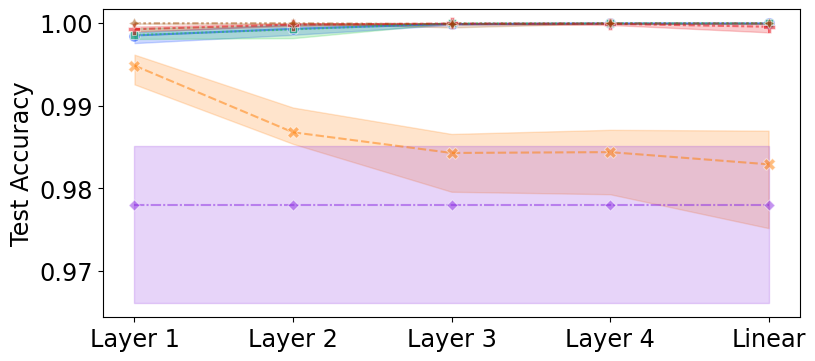

In [12]:
# Create line plot
plt.figure(figsize=(9,4))

line_plot = sns.lineplot(data=df3, x='name', y='val_acc', hue='sender', style='sender', 
                         hue_order=style_order, style_order=style_order,
                         markers=True, dashes=True, markersize=8, alpha=0.5, palette='bright',
                        errorbar=("pi", 100))
# errorbar=("sd",1)) for standard deviation
# errorbar=("pi",100)) for all results

#plt.title("Val Acc of Digit receiver stitched from senders at various layers")
#plt.xlabel('Layer Name')
plt.xlabel('')
plt.ylabel('Test Accuracy', fontsize='xx-large')
#plt.yscale('log')
#plt.xticks(rotation=0)
plt.tick_params(axis='both', labelsize='xx-large')

handles, labels = line_plot.get_legend_handles_labels()
#sorted_labels_handles = sorted(zip(labels, handles))
unsorted_labels_handles = zip(labels, handles)
labels, handles = zip(*unsorted_labels_handles)
plt.legend(handles, labels, title='Stitched Model', loc='upper right', bbox_to_anchor=(1.25, 1), fontsize='xx-large', title_fontsize='xx-large')
plt.legend().remove()
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)
#plt.savefig(f"./results_2e/2e_lin_post_stitch_acc.png", bbox_inches='tight')
plt.savefig(f"./results_2e/2e_lin_post_stitch_acc.pdf", bbox_inches='tight')
plt.show()


## 2e Validation Accuracy of unstitched networks

In [13]:
# Calculate validation accuracy of un-stitched networks on biased data

formatted_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
logfile_name = formatted_time + "_ranks_exp2_log.txt"
save_log_as = f"./results_2e/{logfile_name}"
logtofile(f"Logging to {save_log_as}")
import os 

# exp2 colour_MNIST
csvs_from = os.path.join("../msc_similarity/exp2_ms_with_colorMNIST/results_4_epochs_rank/", "*.csv")
df1 = csv_to_df(csvs_from)

# The models which have no stitch - use to get a first point on the graph for training against real data
ref_models  = {
               'bg':         '^bg$', # these three may learn colours as a shortcut
               'bgonly':     '^bgonly$', 
               'bias':       '^bias$',  
               'unbias':     '^unbias$', # these three have to learn to read digits
               'mix':        '^mix$', 
               'bw':         '^bw$'}

combined_condition = pd.Series([False] * len(df))

accuracies = {}
for k, v in ref_models.items(): 

    model_match = (df['model'].str.contains(v))
    layer_match = (df['name'].str.contains('features.0'))
    condition = (model_match & layer_match)
    print(f"For {k} found {sum(condition)} examples")
    #combined_condition |= condition
    #print(df[condition]['val_acc'])
    #print(df[condition]['val_acc'].mean())
    accuracies[k] = df[condition]['val_acc'].mean()

print("The following networks with validation accuracies measured against bias dataset")
print(accuracies)


Logging to ./results_2e/2024-10-21_22-52-31_ranks_exp2_log.txt
For bg found 6 examples
For bgonly found 6 examples
For bias found 6 examples
For unbias found 6 examples
For mix found 6 examples
For bw found 6 examples
The following networks with validation accuracies measured against bias dataset
{'bg': 1.0, 'bgonly': 0.6857166389624277, 'bias': 0.999783327182134, 'unbias': 0.977983295917511, 'mix': 0.9979666471481323, 'bw': 0.7125666439533234}


In [14]:
# Calculate validation accuracy of stitched networks to 'unbias' at layer 1

formatted_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
logfile_name = formatted_time + "_ranks_exp2_log.txt"
save_log_as = f"./results_2e/{logfile_name}"
logtofile(f"Logging to {save_log_as}")
import os 

# exp2 colour_MNIST
csvs_from = os.path.join("../msc_similarity/exp2_ms_with_colorMNIST/results_4_epochs_rank/", "*.csv")
df1 = csv_to_df(csvs_from)

print("To Layer 1 of unbias")
# The models which have no stitch - use to get a first point on the graph for training against real data
ref_models  = {
               'bg':         '^bg3', # these three may learn colours as a shortcut
               'bgonly':     '^bgonly3', 
               'bias':       '^bias3',  
               'unbias':     '^unbias3', # these three have to learn to read digits
               'mix':        '^mix3', 
               'bw':         '^bw3'}

combined_condition = pd.Series([False] * len(df))

accuracies = {}
for k, v in ref_models.items(): 

    model_match = (df['model'].str.contains(v))
    layer_match = (df['name'].str.contains('features.0'))
    condition = (model_match & layer_match)
    print(f"For {k} found {sum(condition)} examples")
    #combined_condition |= condition
    #print(df[condition]['val_acc'])
    #print(df[condition]['val_acc'].mean())
    accuracies[k] = df[condition]['val_acc'].mean()

print("The following networks with validation accuracies measured against bias dataset")
print(accuracies)


Logging to ./results_2e/2024-10-21_22-52-32_ranks_exp2_log.txt
To Layer 1 of unbias
For bg found 5 examples
For bgonly found 5 examples
For bias found 5 examples
For unbias found 5 examples
For mix found 5 examples
For bw found 5 examples
The following networks with validation accuracies measured against bias dataset
{'bg': 0.9985799789428711, 'bgonly': 0.9992799758911133, 'bias': 0.9985199809074402, 'unbias': 0.9948799729347229, 'mix': 0.9959399819374084, 'bw': 0.978879976272583}


In [15]:
# Calculate validation accuracy of stitched networks to 'unbias' at layer 1

formatted_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
logfile_name = formatted_time + "_ranks_exp2_log.txt"
save_log_as = f"./results_2e/{logfile_name}"
logtofile(f"Logging to {save_log_as}")
import os 

# exp4 colour_MNIST

csvs_from = os.path.join("../msc_similarity/exp4_ms_unbias_to_various_with_colourMNIST/results_4a_rank", "*.csv")
df = csv_to_df(csvs_from)

print("To Layer 1 AFTER unbias")
# The models which have no stitch - use to get a first point on the graph for training against real data
ref_models  = {
               'bg':         '3bg$', # these three may learn colours as a shortcut
               'bgonly':     '3bgonly$', 
               'bias':       '3bias$',  
               'unbias':     '3unbias$', # these three have to learn to read digits
               'mix':        '3mix$', 
               'bw':         '3bw$'}

combined_condition = pd.Series([False] * len(df))

accuracies = {}
for k, v in ref_models.items(): 

    model_match = (df['model'].str.contains(v))
    layer_match = (df['name'].str.contains('features.0'))
    condition = (model_match & layer_match)
    print(f"For {k} found {sum(condition)} examples")
    #combined_condition |= condition
    #print(df[condition]['val_acc'])
    #print(df[condition]['val_acc'].mean())
    accuracies[k] = df[condition]['val_acc'].mean()

print("The following networks with validation accuracies measured against bias dataset")
print(accuracies)


Logging to ./results_2e/2024-10-21_22-52-32_ranks_exp2_log.txt
To Layer 1 AFTER unbias
For bg found 6 examples
For bgonly found 6 examples
For bias found 6 examples
For unbias found 6 examples
For mix found 6 examples
For bw found 6 examples
The following networks with validation accuracies measured against bias dataset
{'bg': 0.9999666611353556, 'bgonly': 0.9848999778429667, 'bias': 0.9810166557629904, 'unbias': 0.9957333107789358, 'mix': 0.9996499717235565, 'bw': 0.9975999593734741}


# Experiment 2e_b - Plot Rank After Stitch - 4 Epoch Trained
Networks trained for 4 epochs. Stitch trained for 10 epochs.
Use the sender's dataset to train and measure stitch
Measure the Rank of the activations in the first layer of the receiver network after the stitch. If the Sender + Stitch were equivalent to the early layers of the receiver network then the rank (after processing by the Receiver) should be unchanged. 

Logging to ./results_2e_b/2024-10-21_22-52-33_ranks_exp2e_b_log.txt
Check number of samples per model:
{'Baseline': 5813, 'Colour': 5813, 'Colour-Only': 5813, 'Correlated': 5813, 'Digit': 5813, 'Noise': 5813}
Check number of samples per model:
{'Baseline': 175, 'Colour': 175, 'Colour-Only': 175, 'Correlated': 175, 'Digit': 175, 'Noise': 175}


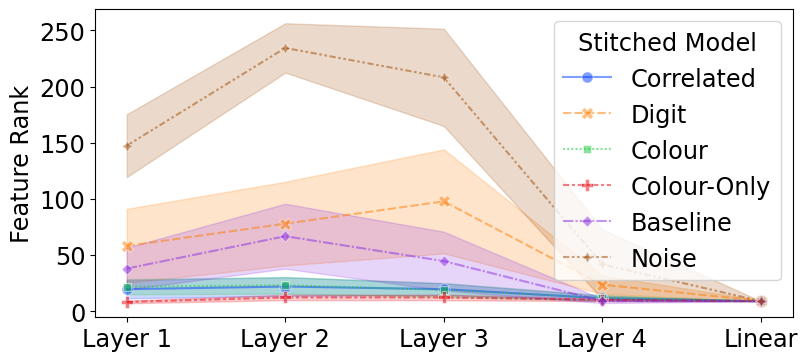

In [16]:
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
logfile_name = formatted_time + "_ranks_exp2e_b_log.txt"
save_log_as = f"./results_2e_b/{logfile_name}"
logtofile(f"Logging to {save_log_as}")
import os 

# styles to reproduce graph A5 of the NeurIPS paper "AllAcc/RankToDigit"
# But with datasets matching sender networks
makeAllRanks = True
if makeAllRanks:
    style_order = ['Correlated', 
                   'Digit',  
                   'Colour', 
                   'Colour-Only',  
                   #'Mix', 
                   'Baseline',  
                   'Noise'
                  ]
    send_models = {'Baseline': '^unbias$',
                   'Colour':         '^bg\d', # these three may learn colours as a shortcut
                   'Colour-Only':     '^bgonly\d', 
                   'Correlated':       '^bias\d',  
                   'Digit':     '^unbias\d', # these three have to learn to read digits
                   #'Mix':        '^mix\d', 
                   #'bw':         '^bw\d',
                   'Noise':      '^X\dunbias' # syntetic random data stitched in
                  }


# exp2 colour_MNIST
csvs_from = os.path.join("../msc_similarity/exp2_ms_with_colorMNIST/results_2e_b_rank/", "*.csv")
df1 = csv_to_df(csvs_from)

# exp1 Synthetic stitch
csvs_from = os.path.join("../msc_similarity/exp1_ms_with_random_dataset/results_4_epochs_rank/", "*.csv")
df2 = csv_to_df(csvs_from)

# select only the data for synthetic data stitched into the unbias-trained network 
df3 = df2[df2['model'].str.contains('^X\dunbias')].copy()

df = pd.concat([df1, df3], ignore_index=True)
del df1, df2, df3

# Edit names to match the whole-network naming
df['name'] = df['name'].str.replace(r'_rcv_', '', regex=True)
df['name'] = df['name'].str.replace(r'^rcv_', '', regex=True)
df['name'] = df['name'].str.replace(r'^send_', '', regex=True)

df['sender'] = 'unknown'
sizes = {}
for k, v in send_models.items(): 
        
    # unsorted dataframe, but filtered to include only the data for one send model type
    selected_set = (df['model'].str.contains(v))
    df.loc[selected_set, 'sender'] = k
    sizes[k] = len((df['model'].str.contains(v)))

# Check numbers of samples per model
print(f"Check number of samples per model:\n{sizes}")

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# cheatingly noted the text names of the layers in order.
# Note that the stitch.s_conv1 layer appears first in the list, even though conceptually it 
# could be considered to be in the middle of the full network at the point of the cut
# This made sense for the truncated networks in part 1 but not 
layer_after_stitch = {3: 'features.4.0.conv1',
                      4: 'features.5.0.conv1',
                      5: 'features.6.0.conv1',
                      6: 'features.7.0.conv1',
                      7: 'originalfc'}

cat_order = ['features.4.0.conv1',  
             'features.5.0.conv1',  
             'features.6.0.conv1', 
             'features.7.0.conv1',  
             'originalfc']

# names for graph tick points as the above are specific to how I've cut and stitched
custom_labels = ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Linear']

combined_condition = pd.Series([False] * len(df))

sizes = {}
for k, v in layer_after_stitch.items(): 

    model_match = (df['model'].str.contains(f"{k}"))
    layer_match = (df['name'].str.contains(v))
    combined_condition |= (model_match & layer_match)

    # Add in the reference model that has no stitch, was trained on unbias dataset but has bias data input to it
    if 'Baseline' in send_models:
        model_match = (df['model'].str.contains(send_models['Baseline']))
        layer_match = (df['name'].str.contains(v))
        combined_condition |= (model_match & layer_match)

df2 = df[combined_condition ].copy() 
df3 = df2[df2['sender'] != 'unknown'].copy()

#########################
sizes = {}
for k, v in send_models.items():         
    # Now that d3 has been filtered down, check again how many samples per model
    sizes[k] = len((df3['model'].str.contains(v)))

# Check numbers of samples per model
print(f"Check number of samples per model:\n{sizes}")
#######################

# Sort the model column and create a categorical type with sorted categories 
# e.g models are X6bgonly or bgonly
df3['name'] = pd.Categorical(df3['name'], categories=cat_order, ordered=True)
# Create line plot
plt.figure(figsize=(9,4))

line_plot = sns.lineplot(data=df3, x='name', y='features_rank', hue='sender', style='sender', 
                         hue_order=style_order, style_order=style_order,
                         markers=True, dashes=True, markersize=8, alpha=0.5, palette='bright',
                        errorbar=("sd",1))

#plt.title("Rank of first layer of Digit receiver after the stitch")
#plt.xlabel('Layer Name')
plt.xlabel('')
plt.ylabel('Feature Rank', fontsize='xx-large')
#plt.yscale('log')
#plt.xticks(rotation=0)
plt.tick_params(axis='both', labelsize='xx-large')

handles, labels = line_plot.get_legend_handles_labels()
#sorted_labels_handles = sorted(zip(labels, handles))
unsorted_labels_handles = zip(labels, handles)
labels, handles = zip(*unsorted_labels_handles)
plt.legend(handles, labels, title='Stitched Model', loc='upper right', bbox_to_anchor=(1, 1), fontsize='xx-large', title_fontsize='xx-large')
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)
#plt.savefig(f"./results_2e/2e_lin_post_stitch_ranks.png", bbox_inches='tight')
plt.savefig(f"./results_2e_b/2e_b_lin_post_stitch_ranks.pdf", bbox_inches='tight')
plt.show()



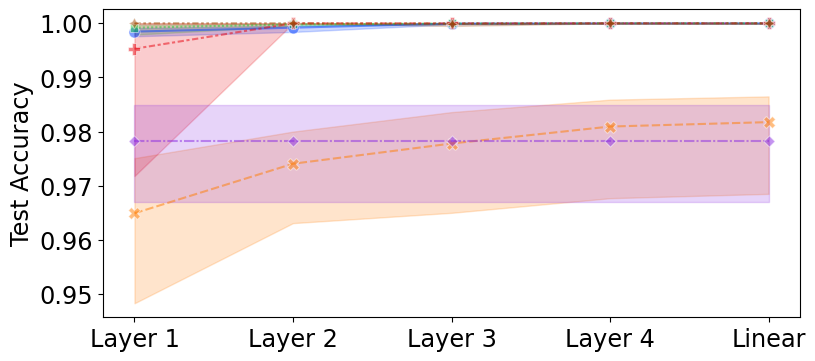

In [17]:
# Create line plot
plt.figure(figsize=(9,4))

line_plot = sns.lineplot(data=df3, x='name', y='val_acc', hue='sender', style='sender', 
                         hue_order=style_order, style_order=style_order,
                         markers=True, dashes=True, markersize=8, alpha=0.5, palette='bright',
                        errorbar=("pi", 100))
# errorbar=("sd",1)) for standard deviation
# errorbar=("pi",100)) for all results

#plt.title("Val Acc of Digit receiver stitched from senders at various layers")
#plt.xlabel('Layer Name')
plt.xlabel('')
plt.ylabel('Test Accuracy', fontsize='xx-large')
#plt.yscale('log')
#plt.xticks(rotation=0)
plt.tick_params(axis='both', labelsize='xx-large')

handles, labels = line_plot.get_legend_handles_labels()
#sorted_labels_handles = sorted(zip(labels, handles))
unsorted_labels_handles = zip(labels, handles)
labels, handles = zip(*unsorted_labels_handles)
plt.legend(handles, labels, title='Stitched Model', loc='upper right', bbox_to_anchor=(1.25, 1), fontsize='xx-large', title_fontsize='xx-large')
plt.legend().remove()
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)
#plt.savefig(f"./results_2e/2e_lin_post_stitch_acc.png", bbox_inches='tight')
plt.savefig(f"./results_2e_b/2e_b_lin_post_stitch_acc.pdf", bbox_inches='tight')
plt.show()


# Experiment 4a - Plot Rank After Stitch - 4 Epoch Trained - Static Unbias
Unbias network as Sender, all others as Receivers
Networks trained for 4 epochs. Stitch trained for 10 epochs.
Measure the Rank of the activations in the first layer of the receiver network after the stitch. If the Sender + Stitch were equivalent to the early layers of the receiver network then the rank (after processing by the Receiver) should be unchanged. 

Logging to ./results_2f/2024-10-21_22-52-35_ranks_exp4a_log.txt
Check number of samples per model:
{'Digit_ref': 5508, 'Colour': 5508, 'Correlated': 5508, 'Digit': 5508, 'Mix': 5508}
Check number of samples per model:
{'Digit_ref': 150, 'Colour': 150, 'Correlated': 150, 'Digit': 150, 'Mix': 150}


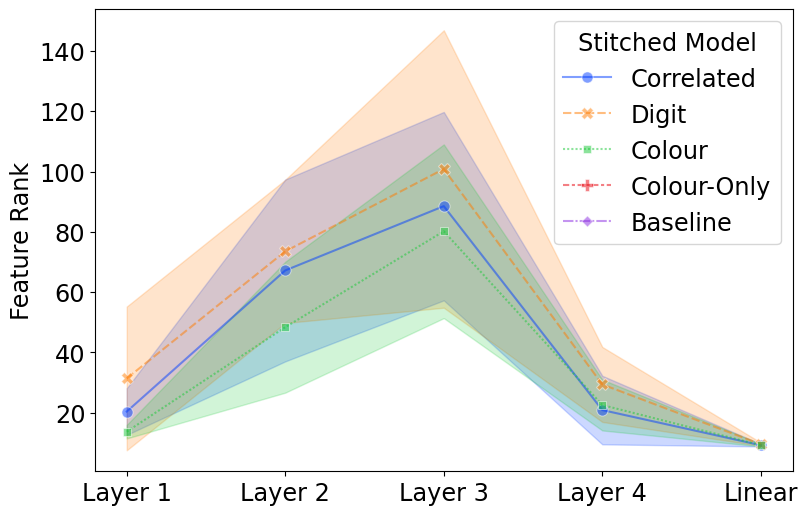

In [18]:
formatted_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
logfile_name = formatted_time + "_ranks_exp4a_log.txt"
save_log_as = f"./results_2f/{logfile_name}"
logtofile(f"Logging to {save_log_as}")
import os 

# exp4 colour_MNIST
csvs_from = os.path.join("../msc_similarity/exp4_ms_unbias_to_various_with_colourMNIST/results_4a_rank", "*.csv")
df = csv_to_df(csvs_from)

# Edit names to match the whole-network naming
df['name'] = df['name'].str.replace(r'_rcv_', '', regex=True)
df['name'] = df['name'].str.replace(r'^rcv_', '', regex=True)
df['name'] = df['name'].str.replace(r'^send_', '', regex=True)

rcv_models  = {'Digit_ref': '^unbias$', # only this string
               'Colour':         '\dbg$', # these three may learn colours as a shortcut
               #'bgonly':     '\dbgonly$', 
               'Correlated':       '\dbias$',  
               'Digit':     '\dunbias$', # these three have to learn to read digits
               'Mix':        '\dmix$', 
               #'bw':         '\dbw$'
              } # No Synth data used here

df['receiver'] = 'unknown'
sizes = {}
for k, v in rcv_models.items(): 
        
    # unsorted dataframe, but filtered to include only the data for one send model type
    selected_set = (df['model'].str.contains(v))
    df.loc[selected_set, 'receiver'] = k
    sizes[k] = len((df['model'].str.contains(v)))

# Check numbers of samples per model
print(f"Check number of samples per model:\n{sizes}")

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

# cheatingly noted the text names of the layers in order.
# Note that the stitch.s_conv1 layer appears first in the list, even though conceptually it 
# could be considered to be in the middle of the full network at the point of the cut
# This made sense for the truncated networks in part 1 but not 
layer_after_stitch = {3: 'features.4.0.conv1',
                      4: 'features.5.0.conv1',
                      5: 'features.6.0.conv1',
                      6: 'features.7.0.conv1',
                      7: 'originalfc'}

cat_order = ['features.4.0.conv1',  
             'features.5.0.conv1',  
             'features.6.0.conv1', 
             'features.7.0.conv1',  
             'originalfc']

# names for graph tick points as the above are specific to how I've cut and stitched
custom_labels = ['Layer 1', 'Layer 2', 'Layer 3', 'Layer 4', 'Linear']

combined_condition = pd.Series([False] * len(df))

sizes = {}
for k, v in layer_after_stitch.items(): 

    model_match = (df['model'].str.contains(f"{k}"))
    layer_match = (df['name'].str.contains(v))
    combined_condition |= (model_match & layer_match)

    # Add in the reference model that has no stitch, was trained on unbias dataset but has bias data input to it
    model_match = (df['model'].str.contains(rcv_models['Digit_ref']))
    layer_match = (df['name'].str.contains(v))
    combined_condition |= (model_match & layer_match)

df2 = df[combined_condition ].copy() 
df3 = df2[df2['receiver'] != 'unknown'].copy()

#########################
sizes = {}
for k, v in rcv_models.items():         
    # Now that d3 has been filtered down, check again how many samples per model
    sizes[k] = len((df3['model'].str.contains(v)))

# Check numbers of samples per model
print(f"Check number of samples per model:\n{sizes}")
#######################

# Sort the model column and create a categorical type with sorted categories 
# e.g models are X6bgonly or bgonly
df3['name'] = pd.Categorical(df3['name'], categories=cat_order, ordered=True)
# Create line plot
plt.figure(figsize=(9,6))
line_plot = sns.lineplot(data=df3, x='name', y='features_rank', hue='receiver', style='receiver', 
                         hue_order=style_order, style_order=style_order,
                         markers=True, dashes=True, markersize=8, alpha=0.5, palette='bright',
                        errorbar=("sd",1))

#plt.title("Rank of first layer of various receivers after the stitch (unbias Sender)")
#plt.xlabel('Layer Name')
plt.xlabel('')
plt.ylabel('Feature Rank', fontsize='xx-large')
#plt.yscale('log')
#plt.xticks(rotation=10)
plt.tick_params(axis='both', labelsize='xx-large')

handles, labels = line_plot.get_legend_handles_labels()
#sorted_labels_handles = sorted(zip(labels, handles))
unsorted_labels_handles = zip(labels[:len(rcv_models)], handles[:len(rcv_models)])
labels, handles = zip(*unsorted_labels_handles)
plt.legend(handles, labels, title='Stitched Model', loc='upper right', bbox_to_anchor=(1, 1), fontsize='xx-large', title_fontsize='xx-large')
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)
plt.savefig(f"./results_4a/4a_lin_post_stitch_ranks.png", bbox_inches='tight')
plt.show()



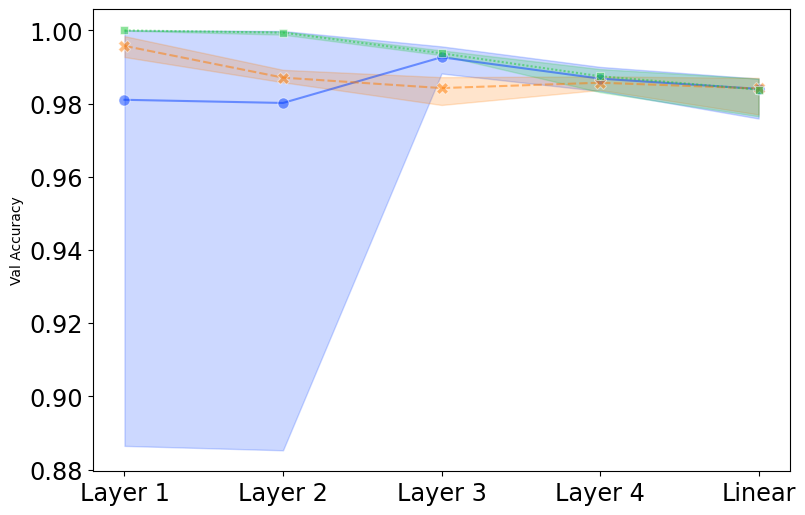

In [19]:
# Create line plot
plt.figure(figsize=(9,6))

line_plot = sns.lineplot(data=df3, x='name', y='val_acc', hue='receiver', style='receiver', 
                         hue_order=style_order, style_order=style_order,
                         markers=True, dashes=True, markersize=8, alpha=0.5, palette='bright',
                        errorbar=("pi",100))

#plt.title("Accuracy of unbias sender stitched to receivers at various layers")
#plt.xlabel('Layer Name')
plt.xlabel('')
plt.ylabel('Val Accuracy')
#plt.yscale('log')
#plt.xticks(rotation=10)
plt.tick_params(axis='both', labelsize='xx-large')

handles, labels = line_plot.get_legend_handles_labels()
#sorted_labels_handles = sorted(zip(labels, handles))
unsorted_labels_handles = zip(labels[:len(rcv_models)], handles[:len(rcv_models)])
labels, handles = zip(*unsorted_labels_handles)
plt.legend(handles, labels, title='Stitched Model', loc='upper right', bbox_to_anchor=(1.25, 1))
plt.legend().remove()
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels)
plt.savefig(f"./results_4a/4a_lin_post_stitch_acc.png", bbox_inches='tight')
plt.show()


## 4a Validation Accuracy of unstitched networks

In [20]:
# Calculate validation accuracy of un-stitched networks on biased data

formatted_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
logfile_name = formatted_time + "_ranks_exp4a_log.txt"
save_log_as = f"./results_4a/{logfile_name}"
logtofile(f"Logging to {save_log_as}")
import os 

# exp2 colour_MNIST
csvs_from = os.path.join("../msc_similarity/exp4_ms_unbias_to_various_with_colourMNIST/results_4a_rank/", "*.csv")
df1 = csv_to_df(csvs_from)

# The models which have no stitch - use to get a first point on the graph for training against real data
ref_models  = {
               'bg':         '^bg$', # these three may learn colours as a shortcut
               'bgonly':     '^bgonly$', 
               'bias':       '^bias$',  
               'unbias':     '^unbias$', # these three have to learn to read digits
               'mix':        '^mix$', 
               'bw':         '^bw$'}

combined_condition = pd.Series([False] * len(df))
print(df1)
accuracies = {}
for k, v in ref_models.items(): 

    model_match = (df['model'].str.contains(v))
    layer_match = (df['name'].str.contains('features.0'))
    condition = (model_match & layer_match)
    print(f"For {k} found {sum(condition)} examples")
    #combined_condition |= condition
    #print(df[condition]['val_acc'])
    #print(df[condition]['val_acc'].mean())
    accuracies[k] = df[condition]['val_acc'].mean()

print("The following networks with validation accuracies measured against bias dataset")
print(accuracies)


Logging to ./results_4a/2024-10-21_22-52-36_ranks_exp4a_log.txt
      Unnamed: 0                            name          model dataset  seed  \
0              0                 send_features.0  unbias6unbias    bias    65   
1              1         send_features.4.0.conv1  unbias6unbias    bias    65   
2              2         send_features.4.0.conv2  unbias6unbias    bias    65   
3              3         send_features.4.1.conv1  unbias6unbias    bias    65   
4              4         send_features.4.1.conv2  unbias6unbias    bias    65   
...          ...                             ...            ...     ...   ...   
5503          17  send_features.7.0.downsample.0     unbias7mix    bias    64   
5504          18         send_features.7.1.conv1     unbias7mix    bias    64   
5505          19         send_features.7.1.conv2     unbias7mix    bias    64   
5506          20                  stitch.s_conv1     unbias7mix    bias    64   
5507          21                 original_rcv